# APRAU — Step 1 Notebook (Académico)

**Curso:** MEI — ISEP  
**Trabalho:** APRAU 2025/26 — Step 1  
**Dataset:** `group_9.csv` (substituir se necessário)  

Este notebook segue o enunciado e está organizado em:

1) **EDA** (Descritiva, Univariada, Bivariada)  
2) **Regressão**: SLR e MLR (com hold-out)  
3) **Classificação**: Logistic Regression, LDA e QDA (Holdout, k=5/k=10, Bootstrap, LOOCV comentado)  
4) **Feature Selection**: Regularização via **LASSO**  
5) **Sumário e Discussão**

> **Nota:** O dataset tem ~3000 linhas (informação fornecida pelo grupo), por isso o **LOOCV** está **comentado** por questões de tempo.

## 0. Setup & Imports

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, accuracy_score,
                             confusion_matrix, classification_report, f1_score)
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Opcional para VIF (multicolinearidade)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Estilo dos gráficos
sns.set(style="whitegrid", context="talk")
pd.set_option("display.max_columns", 200)

## 1. Carregamento e Limpeza de Dados

In [146]:
# --- 1.1 Ler CSV ---
CSV_PATH = "group_9.csv"   # <-- altera se necessário
df = pd.read_csv("group_9.csv")

print("Dimensão do dataset:", df.shape)
display(df.head(3))
df.info()

Dimensão do dataset: (3000, 49)


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,artist_song_count,album_freq,movement_index,intensity_level,verbal_density,purity_score,positivity_index,activity_rate,loudness_intensity,happy_dance,acoustics_instrumental,artists_avg_popularity,tempo_vs_genre,energy_rank_pct,loud_energy_ratio,mood_pca,mood_cluster,acoustic_valence_mood_cluster,explicit,signal_strength,mode_indicator,focus_factor,ambient_level,key_sin,key_cos,duration_log,duration_log_z,time_signature_class_boolean,loudness_yeo,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.221824,-0.949100,0.386456,-0.301858,-0.799810,1.244886,-0.170736,-0.946813,-0.960680,-0.128150,1.269040,-0.978510,-0.306291,-0.013785,-0.359053,1.577655,-0.009441,-0.157539,1.228232,-1.581244,0.0,0.972,0.0,0.0736,0.0787,8.660254e-01,5.000000e-01,2.101556,1.993773,1.0,2.011850,0.0,0.0,-0.128149,-1.114081,0.183527,1,-0.292728,0.972,class_7,0.796292
1,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,-2.089669,1.020640,-0.431042,-0.429684,-1.825498,0.835090,1.176061,-0.946955,-1.342537,0.696317,0.249226,-1.305559,-0.306316,0.488764,0.502909,1.455362,-0.009450,-0.642702,1.562236,-1.581244,1.0,0.952,0.0,0.0135,0.0892,-1.000000e+00,-1.836970e-16,1.720398,0.678143,1.0,0.989422,0.0,0.0,0.696314,-0.630931,0.857540,1,-0.154433,0.952,class_7,1.110125
2,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.221824,0.204605,0.170060,-0.387075,-0.569318,0.514770,-0.119664,-0.867334,-1.107252,-0.438476,-0.447181,-1.022844,-0.295888,0.609406,-0.683491,1.214210,-0.009447,-0.321093,0.226219,-1.581244,0.0,0.913,1.0,0.0769,0.0787,1.224647e-16,-1.000000e+00,1.795323,0.936759,1.0,0.435928,0.0,0.0,-0.438474,-0.942060,0.198153,1,-0.575080,0.913,class_7,0.616958


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration_1                     3000 non-null   float64
 1   duration_2                     3000 non-null   float64
 2   duration_3                     3000 non-null   float64
 3   duration_4                     3000 non-null   float64
 4   duration_5                     3000 non-null   float64
 5   loudness_level                 3000 non-null   float64
 6   popularity_level               3000 non-null   float64
 7   tempo_class                    3000 non-null   float64
 8   time_signature                 3000 non-null   float64
 9   key_mode                       3000 non-null   float64
 10  artist_song_count              3000 non-null   float64
 11  album_freq                     3000 non-null   float64
 12  movement_index                 3000 non-null   f

In [147]:
# --- 1.2 Conversões consistentes (apenas 1x) ---
# Se existirem vírgulas decimais em colunas numéricas, convertemos ',' -> '.'
# Evitamos quebrar colunas já numéricas:
def fix_comma_as_decimal(x: pd.Series) -> pd.Series:
    if x.dtype == object:
        # só tenta substituir se houver vírgulas
        if x.str.contains(',', regex=False).any():
            x = x.str.replace(',', '.', regex=False)
            # tentar converter para numérico; se falhar mantém object
            try_num = pd.to_numeric(x, errors="coerce")
            # Se a conversão tiver produzido alguns números, usamos; caso contrário mantemos texto
            if try_num.notna().sum() > 0:
                return try_num
            return x
        return x
    return x

df = df.apply(fix_comma_as_decimal)

In [148]:
# --- 1.3 Missing values overview ---
na_pct = df.isna().mean().sort_values(ascending=False).to_frame("NA_%")
display(na_pct.head(20))

,NA_%
duration_1,0.0
duration_2,0.0
duration_3,0.0
duration_4,0.0
duration_5,0.0
loudness_level,0.0
popularity_level,0.0
tempo_class,0.0
time_signature,0.0
key_mode,0.0


## 2. EDA — Descritiva e Univariada

In [149]:
# --- 2.1 Descriptive stats para numéricas ---
num_df = df.select_dtypes(include=[np.number]).copy()
desc = num_df.describe().T
desc["skew"] = num_df.skew(numeric_only=True)
desc["kurtosis"] = num_df.kurtosis(numeric_only=True)
display(desc.head(12))

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
duration_1,3000.0,0.129667,0.335992,0.000000,0.000000,0.000000,0.000000,1.000000,2.205886,2.867844
duration_2,3000.0,0.239333,0.426748,0.000000,0.000000,0.000000,0.000000,1.000000,1.222458,-0.505934
duration_3,3000.0,0.347667,0.476309,0.000000,0.000000,0.000000,1.000000,1.000000,0.640068,-1.591375
duration_4,3000.0,0.236333,0.424900,0.000000,0.000000,0.000000,0.000000,1.000000,1.241904,-0.457980
duration_5,3000.0,0.047000,0.211674,0.000000,0.000000,0.000000,0.000000,1.000000,4.283019,16.355159
loudness_level,3000.0,1.646000,1.333145,0.000000,0.000000,2.000000,3.000000,4.000000,0.049514,-1.488613
popularity_level,3000.0,1.730667,1.047772,0.000000,1.000000,1.000000,3.000000,4.000000,0.643058,-1.067581
tempo_class,3000.0,1.016667,0.305101,0.000000,1.000000,1.000000,1.000000,3.000000,0.564254,8.577322
time_signature,3000.0,0.063872,0.838877,-6.712656,0.221824,0.221824,0.221824,2.533318,-4.879960,34.262170
key_mode,3000.0,0.029570,1.005989,-1.511882,-0.920961,0.176466,1.020640,1.611562,-0.020314,-1.289904


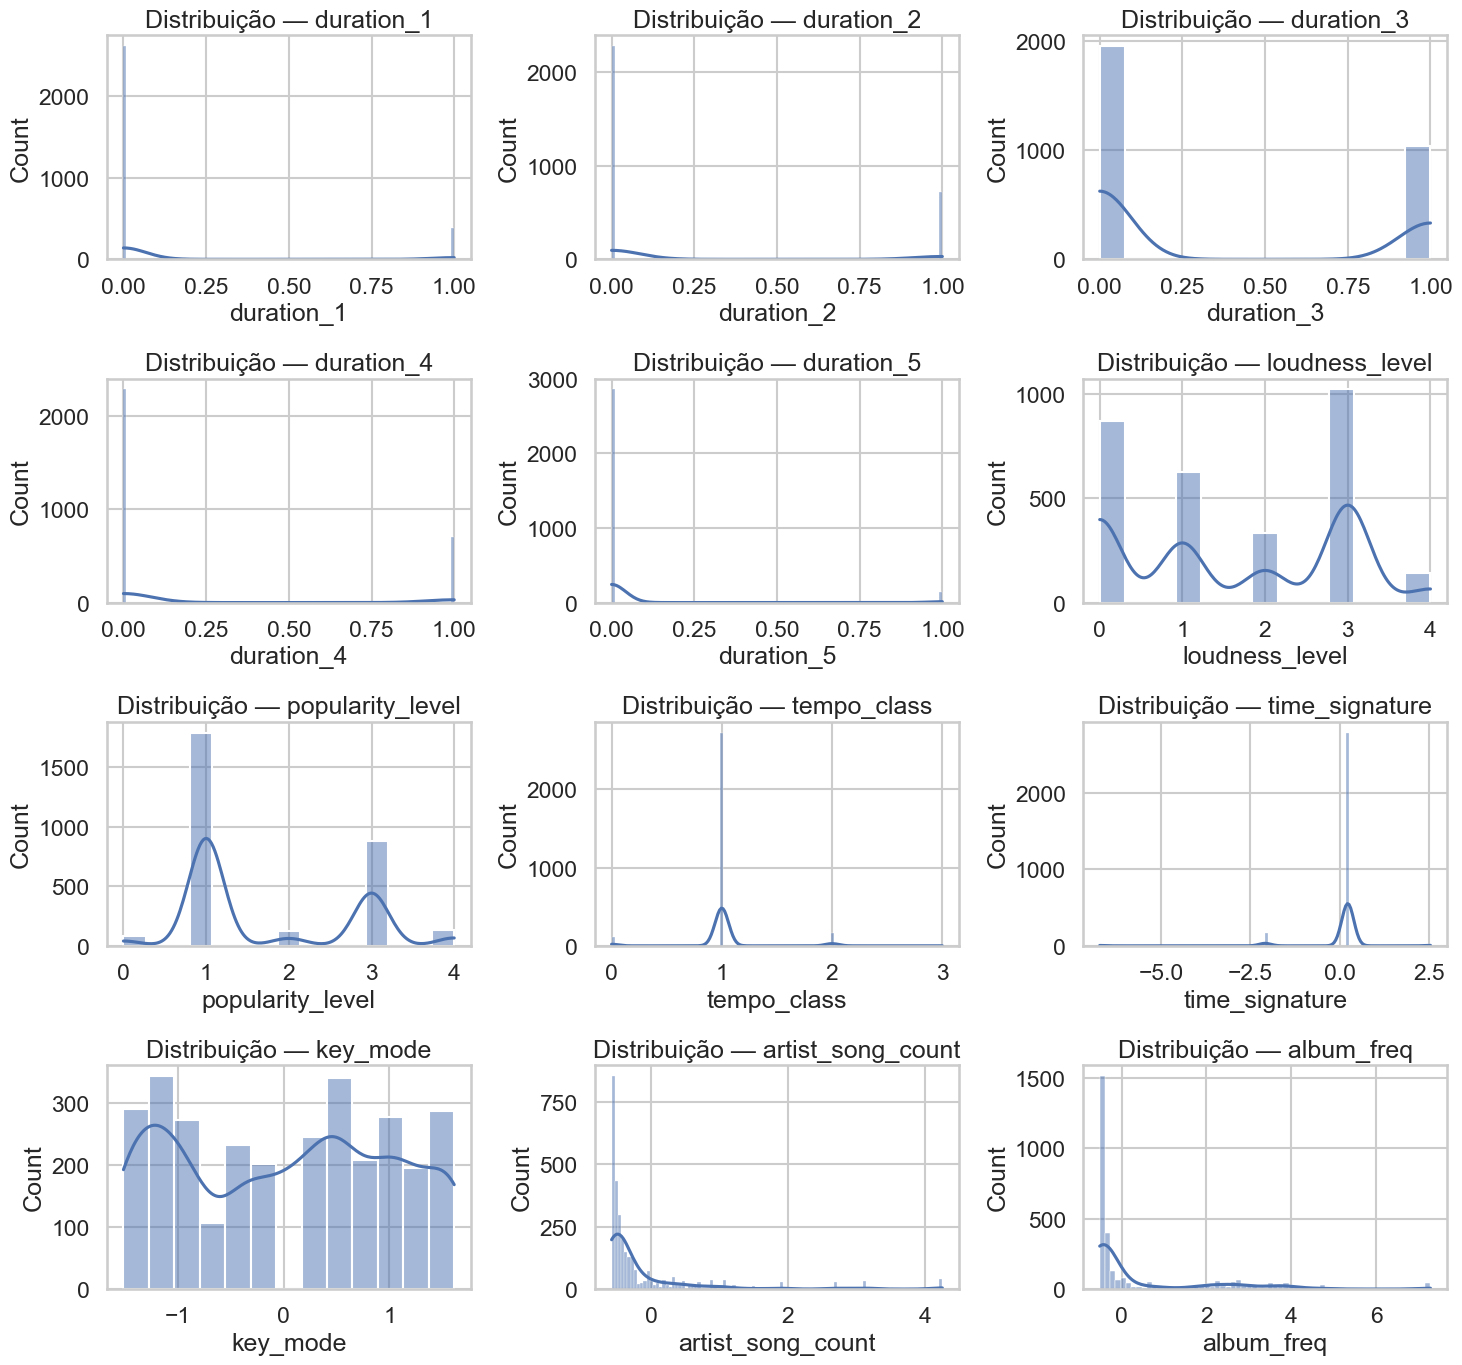

In [150]:
# --- 2.2 Histograma + KDE para as 12 primeiras variáveis numéricas ---
cols = num_df.columns[:12]
n = len(cols)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.5*nrows))
axes = axes.flatten()

for i, c in enumerate(cols):
    sns.histplot(num_df[c].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição — {c}")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

## 3. EDA — Bivariada (correlação e relação com targets)

In [151]:
# Supondo nomes de targets conforme enunciado
TARGET_REG = "target_regression"
TARGET_CLS = "target_class"

# Correlação de Pearson com target_regression (apenas numéricas)
if TARGET_REG in df.columns:
    corr = num_df.corr(numeric_only=True)[TARGET_REG].sort_values(ascending=False).to_frame("corr_with_target_reg")
    display(corr.head(20))
    display(corr.tail(20))
else:
    print("Aviso: 'target_regression' não encontrado no dataset.")

,corr_with_target_reg
target_regression,1.000000
artists_avg_popularity,0.867580
popularity_level,0.710726
loudness_intensity,0.126901
loud_energy_ratio,0.094978
time_signature,0.060668
loudness_yeo,0.052449
temp_zscore,0.049653
activity_rate,0.049653
duration_3,0.048537


,corr_with_target_reg
distorted_movement,-0.013222
acoustics_instrumental,-0.016117
resonance_factor,-0.024101
verbal_density,-0.042077
ambient_level,-0.043674
duration_1,-0.053385
duration_5,-0.060672
duration_log_z,-0.064277
duration_log,-0.064277
happy_dance,-0.065125


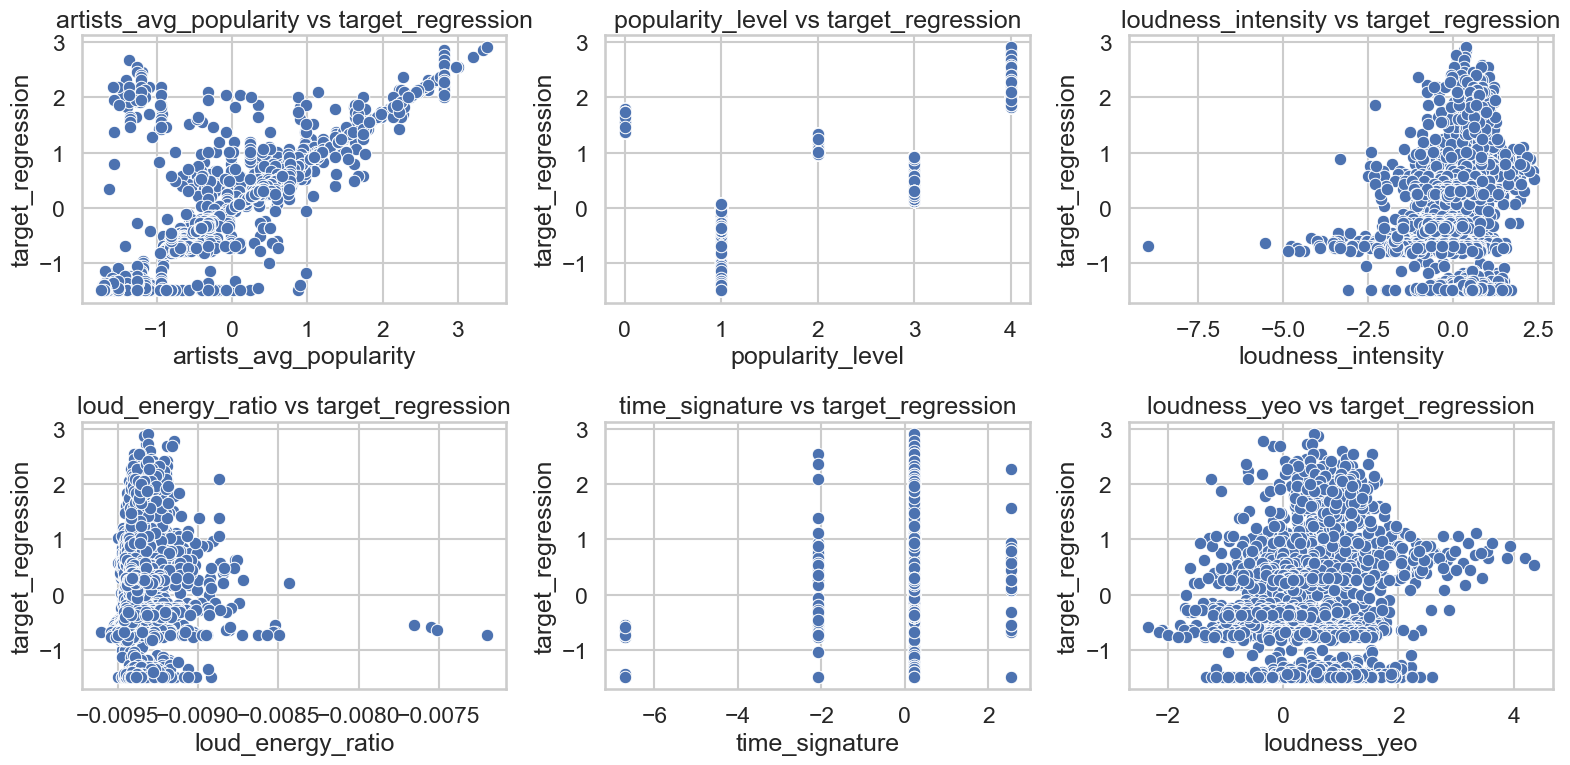

In [152]:
# Scatter de top-6 features mais correlacionadas (ignorando o próprio target)
if TARGET_REG in df.columns:
    top_feats = corr.drop(index=[TARGET_REG], errors="ignore").dropna().head(6).index.tolist()
    if top_feats:
        fig, axes = plt.subplots(2, 3, figsize=(16, 8))
        axes = axes.flatten()
        for i, c in enumerate(top_feats):
            sns.scatterplot(x=df[c], y=df[TARGET_REG], ax=axes[i])
            axes[i].set_title(f"{c} vs {TARGET_REG}")
        plt.tight_layout()
        plt.show()

## 4. Regressão — SLR e MLR (Hold-out)

In [153]:
def evaluate_regression_model(model, X_tr, X_te, y_tr, y_te, model_name=None):
    """
    Avalia um modelo de regressão (Linear, Ridge, Lasso, etc.)
    Retorna métricas e previsões.
    """
    if model_name is None:
        model_name = model.__class__.__name__

    model.fit(X_tr, y_tr)
    preds_tr = model.predict(X_tr)
    preds_te = model.predict(X_te)

    y_tr = np.asarray(y_tr).ravel()
    y_te = np.asarray(y_te).ravel()
    preds_tr = np.asarray(preds_tr).ravel()
    preds_te = np.asarray(preds_te).ravel()

    # Compatibilidade universal
    RMSE_train = np.sqrt(mean_squared_error(y_tr, preds_tr))
    RMSE_test = np.sqrt(mean_squared_error(y_te, preds_te))

    metrics = {
        "MAE_train": mean_absolute_error(y_tr, preds_tr),
        "RMSE_train": RMSE_train,
        "R2_train": r2_score(y_tr, preds_tr),
        "MAE_test": mean_absolute_error(y_te, preds_te),
        "RMSE_test": RMSE_test,
        "R2_test": r2_score(y_te, preds_te)
    }

    print(f"=== {model_name} ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics, preds_te


### 4.1 Simple Linear Regression (SLR) — Várias features candidate

In [154]:
if TARGET_REG in df.columns:
    # Selecionamos apenas colunas numéricas para SLR
    num_cols = df.select_dtypes(include=[np.number]).columns.drop([TARGET_REG], errors="ignore")
    results = []
    for feat in num_cols:
        # dropna para evitar desalinhamentos
        tmp = df[[feat, TARGET_REG]].dropna()
        if tmp.empty:
            continue
        X = tmp[[feat]].values
        y = tmp[TARGET_REG].values.reshape(-1, 1)

        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
        lr = LinearRegression()
        metrics, _ = evaluate_regression_model(lr, X_tr, X_te, y_tr, y_te, model_name=f"SLR({feat})")
        results.append((feat, metrics["R2_test"]))

    slr_rank = pd.DataFrame(results, columns=["Feature", "R2_test"]).sort_values("R2_test", ascending=False)
    display(slr_rank.head(10))

=== SLR(duration_1) ===
MAE_train: 0.8507
RMSE_train: 1.0054
R2_train: 0.0030
MAE_test: 0.7965
RMSE_test: 0.9438
R2_test: -0.0004
=== SLR(duration_2) ===
MAE_train: 0.8550
RMSE_train: 1.0069
R2_train: 0.0000
MAE_test: 0.8037
RMSE_test: 0.9452
R2_test: -0.0032
=== SLR(duration_3) ===
MAE_train: 0.8512
RMSE_train: 1.0060
R2_train: 0.0018
MAE_test: 0.7989
RMSE_test: 0.9427
R2_test: 0.0019
=== SLR(duration_4) ===
MAE_train: 0.8539
RMSE_train: 1.0065
R2_train: 0.0009
MAE_test: 0.8035
RMSE_test: 0.9468
R2_test: -0.0067
=== SLR(duration_5) ===
MAE_train: 0.8492
RMSE_train: 1.0050
R2_train: 0.0038
MAE_test: 0.7977
RMSE_test: 0.9435
R2_test: 0.0003
=== SLR(loudness_level) ===
MAE_train: 0.8547
RMSE_train: 1.0067
R2_train: 0.0005
MAE_test: 0.8051
RMSE_test: 0.9463
R2_test: -0.0057
=== SLR(popularity_level) ===
MAE_train: 0.4643
RMSE_train: 0.7101
R2_train: 0.5027
MAE_test: 0.4244
RMSE_test: 0.6572
R2_test: 0.5150
=== SLR(tempo_class) ===
MAE_train: 0.8543
RMSE_train: 1.0066
R2_train: 0.0007
MAE_

,Feature,R2_test
21,artists_avg_popularity,0.875081
6,popularity_level,0.515034
11,album_freq,0.298709
10,artist_song_count,0.069648
18,loudness_intensity,0.009921
31,focus_factor,0.007150
25,mood_pca,0.006012
16,positivity_index,0.005675
19,happy_dance,0.005176
39,is_instrumental,0.004519


In [155]:
if TARGET_REG in df.columns:
    # Selecionamos apenas colunas numéricas para SLR
    num_cols = df.select_dtypes(include=[np.number]).columns.drop([TARGET_REG], errors="ignore")
    results = []
    for feat in num_cols:
        # dropna para evitar desalinhamentos
        tmp = df[[feat, TARGET_REG]].dropna()
        if tmp.empty:
            continue
        X = tmp[[feat]].values
        y = tmp[TARGET_REG].values.reshape(-1, 1)

        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
        lr = LinearRegression()
        metrics, _ = evaluate_regression_model(lr, X_tr, X_te, y_tr, y_te, model_name=f"SLR({feat})")
        results.append((feat, metrics["R2_test"]))

    slr_rank = pd.DataFrame(results, columns=["Feature", "R2_test"]).sort_values("R2_test", ascending=False)
    display(slr_rank.head(10))

=== SLR(duration_1) ===
MAE_train: 0.8507
RMSE_train: 1.0054
R2_train: 0.0030
MAE_test: 0.7965
RMSE_test: 0.9438
R2_test: -0.0004
=== SLR(duration_2) ===
MAE_train: 0.8550
RMSE_train: 1.0069
R2_train: 0.0000
MAE_test: 0.8037
RMSE_test: 0.9452
R2_test: -0.0032
=== SLR(duration_3) ===
MAE_train: 0.8512
RMSE_train: 1.0060
R2_train: 0.0018
MAE_test: 0.7989
RMSE_test: 0.9427
R2_test: 0.0019
=== SLR(duration_4) ===
MAE_train: 0.8539
RMSE_train: 1.0065
R2_train: 0.0009
MAE_test: 0.8035
RMSE_test: 0.9468
R2_test: -0.0067
=== SLR(duration_5) ===
MAE_train: 0.8492
RMSE_train: 1.0050
R2_train: 0.0038
MAE_test: 0.7977
RMSE_test: 0.9435
R2_test: 0.0003
=== SLR(loudness_level) ===
MAE_train: 0.8547
RMSE_train: 1.0067
R2_train: 0.0005
MAE_test: 0.8051
RMSE_test: 0.9463
R2_test: -0.0057
=== SLR(popularity_level) ===
MAE_train: 0.4643
RMSE_train: 0.7101
R2_train: 0.5027
MAE_test: 0.4244
RMSE_test: 0.6572
R2_test: 0.5150
=== SLR(tempo_class) ===
MAE_train: 0.8543
RMSE_train: 1.0066
R2_train: 0.0007
MAE_

,Feature,R2_test
21,artists_avg_popularity,0.875081
6,popularity_level,0.515034
11,album_freq,0.298709
10,artist_song_count,0.069648
18,loudness_intensity,0.009921
31,focus_factor,0.007150
25,mood_pca,0.006012
16,positivity_index,0.005675
19,happy_dance,0.005176
39,is_instrumental,0.004519


### 4.2 Multiple Linear Regression (MLR) — Hold-out + VIF

In [156]:
if TARGET_REG in df.columns:
    # Seleciona um grupo de features — aqui usamos as 15 melhores do ranking SLR (ou menos se não houver)
    topk = 15
    cand_features = []
    if 'slr_rank' in locals() and not slr_rank.empty:
        cand_features = slr_rank["Feature"].head(topk).tolist()
    else:
        # fallback: todas numéricas exceto o target
        cand_features = df.select_dtypes(include=[np.number]).columns.drop([TARGET_REG], errors="ignore").tolist()[:topk]

    tmp = df[cand_features + [TARGET_REG]].dropna()
    X = tmp[cand_features].values
    y = tmp[TARGET_REG].values.reshape(-1, 1)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalonamento opcional (para regressão linear clássica não é obrigatório, mas ajuda em VIF)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    mlr = LinearRegression()
    metrics_mlr, preds = evaluate_regression_model(mlr, X_tr_s, X_te_s, y_tr, y_te, model_name="MLR")

    # --- VIF --- (usar dados de treino escalados)
    X_tr_s_const = sm.add_constant(X_tr_s, has_constant='add')
    vif_df = pd.DataFrame({
        "Feature": ["const"] + cand_features,
        "VIF": [variance_inflation_factor(X_tr_s_const, i) for i in range(X_tr_s_const.shape[1])]
    })
    display(vif_df.sort_values("VIF", ascending=False))

=== MLR ===
MAE_train: 0.2589
RMSE_train: 0.4380
R2_train: 0.8108
MAE_test: 0.2176
RMSE_test: 0.3264
R2_test: 0.8804


,Feature,VIF
7,mood_pca,35.519459
8,positivity_index,27.019205
9,happy_dance,19.956577
12,loudness_yeo,9.485543
5,loudness_intensity,7.292867
6,focus_factor,3.109132
10,is_instrumental,2.497277
1,artists_avg_popularity,2.186065
3,album_freq,2.079127
2,popularity_level,1.801834


## 5. Classificação — Logistic, LDA e QDA

In [157]:
# --- 5.1 Preparação ---
if TARGET_CLS in df.columns:
    # Selecionar features numéricas (LDA/QDA requerem numéricas)
    feat_num = df.select_dtypes(include=[np.number]).columns.drop([TARGET_REG], errors="ignore")

    # Remover o target numérico se existir, manter apenas variáveis explicativas
    Xc = df[feat_num].drop(columns=[TARGET_CLS], errors="ignore").copy()
    yc = df[TARGET_CLS].copy()

    # Se o target for string/categórico, codificar
    if yc.dtype == object:
        le = LabelEncoder()
        yc = le.fit_transform(yc.astype(str))

    # Remover linhas com NaN
    cls_df = pd.concat([Xc, pd.Series(yc, name=TARGET_CLS)], axis=1).dropna()
    Xc = cls_df.drop(columns=[TARGET_CLS]).values
    yc = cls_df[TARGET_CLS].values

    # Escalonamento
    scaler = StandardScaler()
    Xc_s = scaler.fit_transform(Xc)

    # Hold-out estratificado
    X_tr, X_te, y_tr, y_te = train_test_split(Xc_s, yc, test_size=0.2, random_state=42, stratify=yc)
    print("Train shape:", X_tr.shape, "| Test shape:", X_te.shape, "| Classes:", np.unique(yc))

    # Modelos
    models = {
        "LogisticRegression": LogisticRegression(max_iter=2000),
        "LDA": LinearDiscriminantAnalysis(),
        "LDA(shrink)": LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"),
        "QDA": QuadraticDiscriminantAnalysis(),
        "QDA(reg=0.1)": QuadraticDiscriminantAnalysis(reg_param=0.1),
    }

    def print_summary(name, y_true, y_pred):
        print(f"\n=== {name} (Hold-out) ===")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("F1 (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
        print("Classification report:")
        print(classification_report(y_true, y_pred, zero_division=0))
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion matrix:\n", cm)

    for name, mdl in models.items():
        mdl.fit(X_tr, y_tr)
        yhat = mdl.predict(X_te)
        print_summary(name, y_te, yhat)
else:
    print("Aviso: 'target_class' não encontrado no dataset; secção de classificação será ignorada.")

Train shape: (2400, 47) | Test shape: (600, 47) | Classes: [0 1 2]

=== LogisticRegression (Hold-out) ===
Accuracy: 0.9783333333333334
F1 (macro): 0.9783299473876127
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       200
           1       0.96      0.98      0.97       200
           2       1.00      1.00      1.00       200

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Confusion matrix:
 [[191   9   0]
 [  4 196   0]
 [  0   0 200]]

=== LDA (Hold-out) ===
Accuracy: 1.0
F1 (macro): 1.0
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg    

In [158]:
# --- 5.2 Cross-Validation & Bootstrap ---
if TARGET_CLS in df.columns:
    def cv_scores(model, X, y, k):
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        accs, f1s = [], []
        for tr, te in skf.split(X, y):
            model.fit(X[tr], y[tr])
            yhat = model.predict(X[te])
            accs.append(accuracy_score(y[te], yhat))
            f1s.append(f1_score(y[te], yhat, average='macro', zero_division=0))
        return np.mean(accs), np.std(accs), np.mean(f1s), np.std(f1s)

    for name, mdl in {
        "LDA": LinearDiscriminantAnalysis(),
        "LDA(shrink)": LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"),
        "QDA": QuadraticDiscriminantAnalysis(),
        "QDA(reg=0.1)": QuadraticDiscriminantAnalysis(reg_param=0.1),
        "LogReg": LogisticRegression(max_iter=2000),
    }.items():
        for k in [5, 10]:
            acc_m, acc_s, f1_m, f1_s = cv_scores(mdl, Xc_s, yc, k)
            print(f"{name} | {k}-Fold -> Acc: {acc_m:.4f} ± {acc_s:.4f} | F1(macro): {f1_m:.4f} ± {f1_s:.4f}")

    # Bootstrap (OOB)
    rng = np.random.default_rng(42)
    B = 200
    accs_bs, f1_bs = [], []
    model_bs = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
    n = Xc_s.shape[0]

    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        oob = np.setdiff1d(np.arange(n), np.unique(idx))
        if len(oob) == 0:
            continue
        model_bs.fit(Xc_s[idx], yc[idx])
        yhat = model_bs.predict(Xc_s[oob])
        accs_bs.append(accuracy_score(yc[oob], yhat))
        f1_bs.append(f1_score(yc[oob], yhat, average='macro', zero_division=0))

    print(f"\nBootstrap (LDA shrink, {B} repetições) -> Acc (OOB): {np.mean(accs_bs):.4f} | F1(macro): {np.mean(f1_bs):.4f}")

    # LOOCV (comentado — 3000 linhas pode ser pesado)
loo = LeaveOneOut()
accs, f1s = [], []
for tr, te in loo.split(Xc_s, yc):
     mdl = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
     mdl.fit(Xc_s[tr], yc[tr])
     yhat = mdl.predict(Xc_s[te])
     accs.append(accuracy_score(yc[te], yhat))
     f1s.append(f1_score(yc[te], yhat, average='macro', zero_division=0))
     print(f"LOOCV (LDA shrink) -> Acc: {np.mean(accs):.4f} | F1(macro): {np.mean(f1s):.4f}")

LDA | 5-Fold -> Acc: 0.9803 ± 0.0393 | F1(macro): 0.9804 ± 0.0392
LDA | 10-Fold -> Acc: 0.9893 ± 0.0320 | F1(macro): 0.9894 ± 0.0319
LDA(shrink) | 5-Fold -> Acc: 0.9040 ± 0.0067 | F1(macro): 0.9047 ± 0.0064
LDA(shrink) | 10-Fold -> Acc: 0.9053 ± 0.0198 | F1(macro): 0.9061 ± 0.0194
QDA | 5-Fold -> Acc: 1.0000 ± 0.0000 | F1(macro): 1.0000 ± 0.0000
QDA | 10-Fold -> Acc: 1.0000 ± 0.0000 | F1(macro): 1.0000 ± 0.0000
QDA(reg=0.1) | 5-Fold -> Acc: 0.8670 ± 0.0156 | F1(macro): 0.8636 ± 0.0160
QDA(reg=0.1) | 10-Fold -> Acc: 0.8690 ± 0.0264 | F1(macro): 0.8656 ± 0.0277
LogReg | 5-Fold -> Acc: 0.9670 ± 0.0046 | F1(macro): 0.9670 ± 0.0047
LogReg | 10-Fold -> Acc: 0.9667 ± 0.0047 | F1(macro): 0.9667 ± 0.0048

Bootstrap (LDA shrink, 200 repetições) -> Acc (OOB): 0.9074 | F1(macro): 0.9082
LOOCV (LDA shrink) -> Acc: 1.0000 | F1(macro): 1.0000
LOOCV (LDA shrink) -> Acc: 1.0000 | F1(macro): 1.0000
LOOCV (LDA shrink) -> Acc: 0.6667 | F1(macro): 0.6667
LOOCV (LDA shrink) -> Acc: 0.7500 | F1(macro): 0.750

## 6. Feature Selection — LASSO (para `target_regression`)

In [159]:
if TARGET_REG in df.columns:
    # Selecionar apenas numéricas
    features_num = df.select_dtypes(include=[np.number]).columns.drop([TARGET_REG], errors="ignore")
    tmp = df[list(features_num) + [TARGET_REG]].dropna()

    X = tmp[features_num].values
    y = tmp[TARGET_REG].values

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=42, n_alphas=100).fit(Xs, y)
    coef = pd.Series(lasso.coef_, index=features_num)
    selected = coef[coef != 0].sort_values(key=np.abs, ascending=False)

    print("Alpha escolhido (CV):", lasso.alpha_)
    print(f"Nº de features selecionadas: {selected.shape[0]}")
    display(selected.head(20).to_frame("coef"))
else:
    print("Aviso: 'target_regression' não encontrado; LASSO não executado.")

Alpha escolhido (CV): 0.11409098774725084
Nº de features selecionadas: 3


,coef
artists_avg_popularity,0.592566
popularity_level,0.185955
album_freq,-0.072382


## 7. Sumário e Discussão

**Regressão (SLR vs MLR):**  
- SLR: indicar melhor feature (R² hold-out).  
- MLR: discutir melhoria vs SLR; comentar VIF (multicolinearidade).  

**Classificação (LogReg, LDA, QDA):**  
- Comparar acurácia e F1 (hold-out e CV).  
- Avaliar impacto de *shrinkage* no LDA e regularização do QDA.  
- Comentar variância com Bootstrap (e LOOCV se testado).  

**Feature Selection (LASSO):**  
- Quais features ficaram com coeficiente ≠ 0 e se o desempenho da regressão melhora com elas.  

**Limitações e trabalhos futuros:**  
- Balanceamento de classes, normalização, tuning de hiperparâmetros, validações adicionais, e análise de *feature importance* mais profunda.

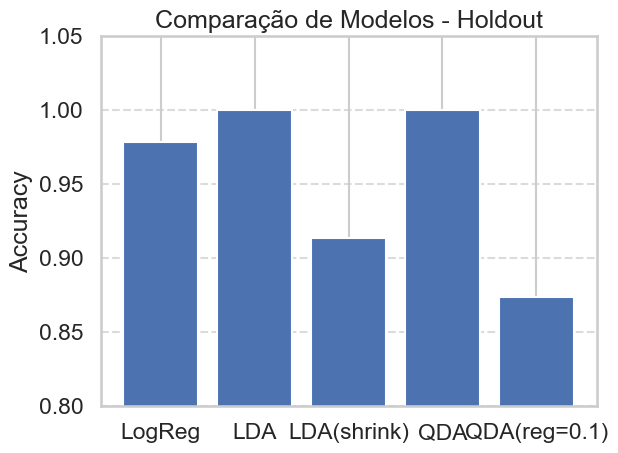

In [160]:
import matplotlib.pyplot as plt

models = ["LogReg", "LDA", "LDA(shrink)", "QDA", "QDA(reg=0.1)"]
acc = [0.9783, 1.0, 0.9133, 1.0, 0.8733]

plt.bar(models, acc)
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.05)
plt.title("Comparação de Modelos - Holdout")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
